In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

%matplotlib inline
sns.set_theme(style="whitegrid")

In [8]:
df = pd.read_csv("thyroid_cancer_risk_data.csv")

In [9]:
df.head()

,Patient_ID,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,1,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,2,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,3,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,4,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,5,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Patient_ID           212691 non-null  int64  
 1   Age                  212691 non-null  int64  
 2   Gender               212691 non-null  object 
 3   Country              212691 non-null  object 
 4   Ethnicity            212691 non-null  object 
 5   Family_History       212691 non-null  object 
 6   Radiation_Exposure   212691 non-null  object 
 7   Iodine_Deficiency    212691 non-null  object 
 8   Smoking              212691 non-null  object 
 9   Obesity              212691 non-null  object 
 10  Diabetes             212691 non-null  object 
 11  TSH_Level            212691 non-null  float64
 12  T3_Level             212691 non-null  float64
 13  T4_Level             212691 non-null  float64
 14  Nodule_Size          212691 non-null  float64
 15  Thyroid_Cancer_Ri

In [11]:
df.describe()

,Patient_ID,Age,TSH_Level,T3_Level,T4_Level,Nodule_Size
count,212691.00000,212691.000000,212691.000000,212691.000000,212691.000000,212691.000000
mean,106346.00000,51.918497,5.045102,2.001727,8.246204,2.503403
std,61398.74739,21.632815,2.860264,0.866248,2.164188,1.444631
min,1.00000,15.000000,0.100000,0.500000,4.500000,0.000000
25%,53173.50000,33.000000,2.570000,1.250000,6.370000,1.250000
50%,106346.00000,52.000000,5.040000,2.000000,8.240000,2.510000
75%,159518.50000,71.000000,7.520000,2.750000,10.120000,3.760000
max,212691.00000,89.000000,10.000000,3.500000,12.000000,5.000000


In [12]:
df.describe(include=['object'])

,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,Thyroid_Cancer_Risk,Diagnosis
count,212691,212691,212691,212691,212691,212691,212691,212691,212691,212691,212691
unique,2,10,5,2,2,2,2,2,2,3,2
top,Female,India,Caucasian,No,No,No,No,No,No,Low,Benign
freq,127527,42496,63669,148866,180831,159673,170260,148805,170098,108388,163196


Diagnosis
Benign       163196
Malignant     49495
Name: count, dtype: int64


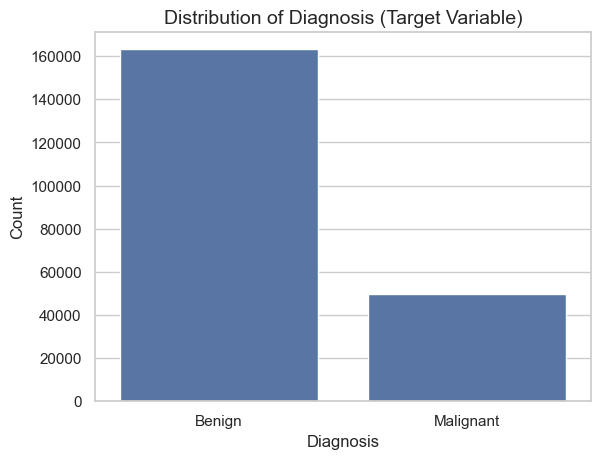

In [17]:
plt.Figure(figsize=(8, 6))
sns.countplot(data=df, x='Diagnosis')
plt.title('Distribution of Diagnosis (Target Variable)', fontsize=14)
plt.xlabel('Diagnosis')
plt.ylabel('Count')

print(df['Diagnosis'].value_counts())

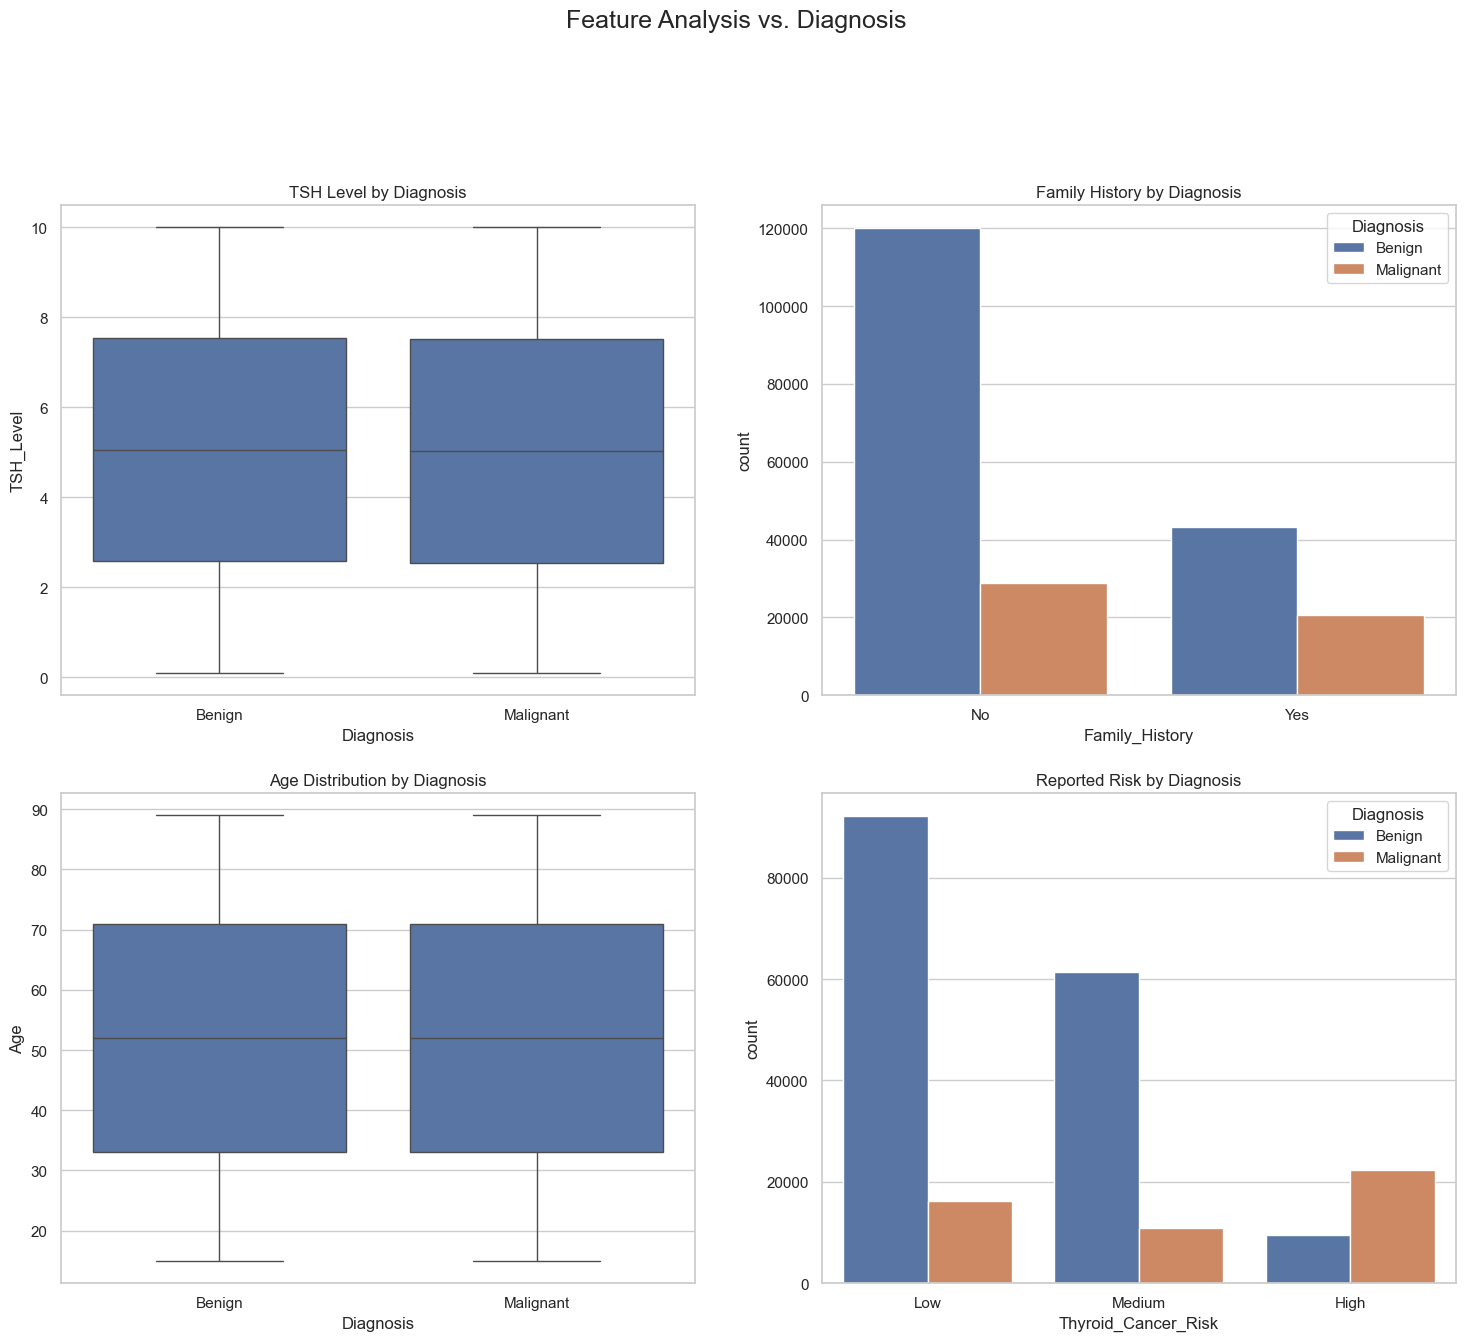

In [19]:
# Set up a figure for multiple plots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Feature Analysis vs. Diagnosis', fontsize=18, y=1.02)

# 1. TSH Level vs. Diagnosis (Boxplot)
sns.boxplot(ax=axes[0, 0], data=df, x='Diagnosis', y='TSH_Level')
axes[0, 0].set_title('TSH Level by Diagnosis')

# 2. Family History vs. Diagnosis (Countplot)
sns.countplot(ax=axes[0, 1], data=df, x='Family_History', hue='Diagnosis')
axes[0, 1].set_title('Family History by Diagnosis')

# 3. Age vs. Diagnosis (Boxplot)
sns.boxplot(ax=axes[1, 0], data=df, x='Diagnosis', y='Age')
axes[1, 0].set_title('Age Distribution by Diagnosis')

# 4. Thyroid Cancer Risk vs. Diagnosis (Countplot)
sns.countplot(ax=axes[1, 1], data=df, x='Thyroid_Cancer_Risk', hue='Diagnosis', order=['Low', 'Medium', 'High'])
axes[1, 1].set_title('Reported Risk by Diagnosis')

plt.show()

In [21]:
df_processed = df.drop(['Patient_ID','Country','Ethnicity'], axis=1) #unuesed columns
print(df_processed)

        Age  Gender Family_History  ... Nodule_Size Thyroid_Cancer_Risk  Diagnosis
0        66    Male             No  ...        1.08                 Low     Benign
1        29    Male             No  ...        4.05                 Low     Benign
2        86    Male             No  ...        4.61                 Low     Benign
3        75  Female             No  ...        2.46              Medium     Benign
4        35  Female            Yes  ...        2.11                High     Benign
...     ...     ...            ...  ...         ...                 ...        ...
212686   58  Female             No  ...        1.48                 Low     Benign
212687   89    Male             No  ...        4.46              Medium     Benign
212688   72  Female             No  ...        2.36              Medium     Benign
212689   85  Female             No  ...        1.54              Medium     Benign
212690   46  Female             No  ...        2.53                 Low  Malignant

[21

In [22]:
# Numerical columns for scaling
numerical_cols = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']

# Categorical columns for encoding
categorical_cols = [
    'Gender', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency',
    'Smoking', 'Obesity', 'Diabetes', 'Thyroid_Cancer_Risk'
]

# Target column
target_col = 'Diagnosis'

In [25]:
encoders = {}

print("encoding categorical columns")
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le
    print(f"Encoded {col}: {list(le.classes_)}")

print("encoding target column")
le_target = LabelEncoder()
df_processed[target_col] = le_target.fit_transform(df_processed[target_col])
encoders[target_col] = le_target
print(f"Encoded {target_col}: {list(le_target.classes_)}")

encoding categorical columns
Encoded Gender: [np.int64(0), np.int64(1)]
Encoded Family_History: [np.int64(0), np.int64(1)]
Encoded Radiation_Exposure: [np.int64(0), np.int64(1)]
Encoded Iodine_Deficiency: [np.int64(0), np.int64(1)]
Encoded Smoking: [np.int64(0), np.int64(1)]
Encoded Obesity: [np.int64(0), np.int64(1)]
Encoded Diabetes: [np.int64(0), np.int64(1)]
Encoded Thyroid_Cancer_Risk: [np.int64(0), np.int64(1), np.int64(2)]
encoding target column
Encoded Diagnosis: ['Benign', 'Malignant']


In [26]:
scaler = StandardScaler()
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])
df_processed.head()

,Age,Gender,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,0.650934,1,0,1,0,0,0,0,1.512066,-0.382947,-0.963968,-0.985308,1,0
1,-1.059435,1,0,1,0,0,0,0,-1.124060,-0.313683,1.059890,1.070585,1,0
2,1.575458,1,0,0,0,0,0,0,0.424751,0.679107,1.073752,1.458229,1,0
3,1.066970,0,0,0,0,0,0,0,-0.330426,0.713739,1.290924,-0.030045,2,0
4,-0.782077,0,1,1,0,0,0,0,1.417669,0.124991,1.138441,-0.272322,0,0


In [27]:
x = df_processed.drop(target_col, axis=1)
y = df_processed[target_col]
original_features = list(x.columns)
print(original_features) #model will use these features

['Age', 'Gender', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size', 'Thyroid_Cancer_Risk']


In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {Xtrain.shape}")
print(f"Test set shape: {Xtest.shape}")

Training set size: (170152, 13)
Test set shape: (42539, 13)


In [30]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
print("Training the model")
model.fit(Xtrain, ytrain)
print("Model training completed")

Training the model
Model training completed


In [31]:
y_pred = model.predict(Xtest)

print("model evaluation")
print("Accuracy:", accuracy_score(ytest, y_pred))

model evaluation
Accuracy: 0.8263710947601025


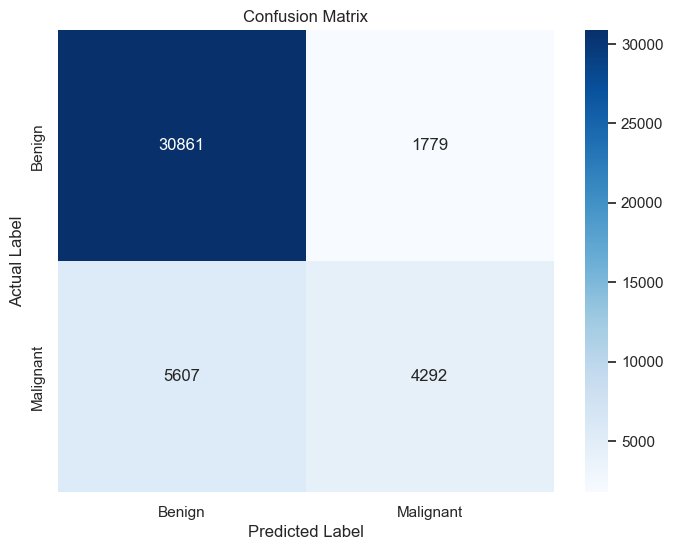

In [34]:
cm = confusion_matrix(ytest, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
print("Classification Report:")
print(classification_report(ytest, y_pred, target_names=le_target.classes_))

Classification Report:
              precision    recall  f1-score   support

      Benign       0.85      0.95      0.89     32640
   Malignant       0.71      0.43      0.54      9899

    accuracy                           0.83     42539
   macro avg       0.78      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539



In [36]:
print("saving the model and encoders")
joblib.dump(model, 'thyroid_cancer_risk_model.pkl')
joblib.dump(encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
model_columns = {
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'original_features': original_features,
    'target_col': target_col
}
joblib.dump(model_columns, 'model_columns.pkl')
print("Model and encoders saved successfully")

saving the model and encoders
Model and encoders saved successfully
